Here we consider TTGO for various 2D benchmark functions without conditioning (task parameters).

Try:
 - 2D Rosenbrock function (unique global optima)
 - 2D Himmelblaue function (multiple global optima)
 - 2D GMM (multiple/unique global optima)
 - 2D Sine function ( infinite number of global optima)
 - Something of your own
 

Copyright (c) 2008 Idiap Research Institute, http://www.idiap.ch/

Written by Suhan Shetty <suhan.shetty@idiap.ch>,


In [1]:
import torch
import numpy as np
import sys
sys.path.append('../')
import tt_utils
from ttgo import TTGO
from fcn_plotting_utils import plot_surf, plot_contour
%load_ext autoreload
np.set_printoptions(precision=3)
%autoreload 2

/Users/sshetty/miniconda3/envs/pyml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

##### Define the objective function (a pdf, need not be normalized)

Activate one of the following cells:

In [3]:
#Himmelbalue2D
from test_fcns import Himmelblaue_2D
L=5
n = 2 # Dimension of the domain
a=11; b=7;
pdf, cost = Himmelblaue_2D(alpha=1, a=a, b=b)
print("This has multiple global optima")
z_max = 2000 # for plotting
log_norm = True # for plotting

This has multiple global optima


##### or

In [4]:
# # Rosenbrock 2D
# from test_fcns import Rosenbrock_2D
# L=2
# n = 2 # Dimension of the domain
# a=1;b=100
# pdf, cost = Rosenbrock_2D(a=a,b=b,alpha=1)
# print("Global optima is at: ", (a,a**2))
# z_max = 2000 # for plotting
# log_norm = True # for plotting

or

In [5]:
# # Sine 2D
# from test_fcns import sine_nD
# L=2
# n = 2 # Dimension of the domain
# pdf, cost = sine_nD(n=n,device=device)
# print("An infinite number of solutions exist ")
# z_max = 2 # for plotting
# log_norm = True # for plotting

##### or

In [6]:
# # Mixture of Gaussians (un-normalized)
# from test_fcns import gmm 
# L = 2
# n = 2 # Dimension of the domain
# nmix = 4
# mx_coef = np.random.uniform(0,1,(nmix,))
# mx_coef = torch.from_numpy(mx_coef/np.sum(mx_coef)).to(device)
# mu = torch.from_numpy(np.random.uniform(-L,L,(nmix,n))).to(device)
# pdf, cost = gmm(n=n,nmix=nmix,L=L,mx_coef=mx_coef,mu=mu,s=0.2,device=device)
# print("centers: ",mu)
# print("\nPDF at centers: ", pdf(mu))
# z_max = 2 # for plotting
# log_norm = False # for plotting

##### Discretize the domain

In [7]:
# Define the domain of the function
d = 100 # discretization of each axis
domain = [torch.linspace(-L,L,d).to(device)]*2

In [8]:
# Find the tt-model correspondin to the pdf
tt_model = tt_utils.cross_approximate(fcn=pdf,  domain=domain, 
                        rmax=200, nswp=10, eps=1e-3, verbose=True, 
                        kickrank=10, device=device)

cross device is cpu
Cross-approximation over a 2D domain containing 10000 grid points:
iter: 0  | eps: 8.531e-01 | time:   0.0076 | largest rank:   1
iter: 1  | eps: 4.465e-02 | time:   0.0268 | largest rank:  11
iter: 2  | eps: 3.518e-04 | time:   0.0448 | largest rank:  21 <- converged: eps < 0.001
Did 9900 function evaluations, which took 0.002068s (4.788e+06 evals/s)



In [9]:
# Refine the discretization and interpolate the model
scale_factor = 20
site_list = torch.arange(len(domain))#len(domain_task)+torch.arange(len(domain_decision))
domain_new = tt_utils.refine_domain(domain=domain, 
                                    site_list=site_list,
                                    scale_factor=scale_factor, device=device)
tt_model_new = tt_utils.refine_model(tt_model=tt_model, 
                                    site_list=site_list,
                                    scale_factor=scale_factor, device=device)

##### Find the TT-Model

In [10]:
ttgo = TTGO(tt_model = tt_model_new,domain=domain_new,cost=cost,device=device)
print("TT-Rank: ", ttgo.tt_model.ranks_tt)

TT-Rank:  tensor([ 1, 14,  1])


##### Sample from the TT-distribution (no conditioning)

In [11]:
n_samples = 100 
alpha = 0.75 # choose prioritized sampling parameter (0,1)
samples = ttgo.sample_tt(n_samples=n_samples, alpha=alpha)

Choose the best solution (or top-k solution)

In [19]:
best_estimate = ttgo.choose_best_sample(samples)[0] # best estimate
k = 10 # number of solutions needed
top_k_estimate = ttgo.choose_top_k_sample(samples,k=k)[0] # top-k estimates for multiple solutions

In [20]:
best_estimate.shape

torch.Size([1, 2])

In [21]:
top_k_estimate.shape

torch.Size([10, 2])

In [22]:
print("Cost at estimated optima: ", cost(best_estimate))
print("Cost at top-k proposals: ", cost(top_k_estimate))

Cost at estimated optima:  tensor([0.0007])
Cost at top-k proposals:  tensor([0.0007, 0.0016, 0.0016, 0.0035, 0.0063, 0.0098, 0.0127, 0.0129, 0.0171,
        0.0174])


In [23]:
best_estimate

tensor([[ 3.5808, -1.8485]])

Fine tune the TTGO estimate using gradient-based optimization

In [24]:
ttgo_optimized, _ = ttgo.optimize(best_estimate)
print("Optimal cost: ", cost(ttgo_optimized))
print("Optimal pdf: ", pdf(ttgo_optimized))

Optimal cost:  tensor([1.9373e-06])
Optimal pdf:  tensor([1.0000])


In [25]:
print("TTGO Approximation of Optima: ", best_estimate)
print("Optima: ", ttgo_optimized)

TTGO Approximation of Optima:  tensor([[ 3.5808, -1.8485]])
Optima:  tensor([[ 3.5846, -1.8481]])


In [26]:
ttgo_optimized_k = 1*top_k_estimate
for i, x in enumerate(ttgo_optimized_k):
    ttgo_optimized_k[i],_ = ttgo.optimize(x)


### Visualize  Samples from TT Model

In [27]:
def cost_plot(x):
    x = torch.from_numpy(x).to(device)
    out =  cost(x).cpu()
    if not (type(out) is np.ndarray):
        out = out.numpy()
    return out
def pdf_plot(x):
    x = torch.from_numpy(x).to(device)
    out =  pdf(x).cpu()
    if not (type(out) is np.ndarray):
        out = out.numpy()
    return out

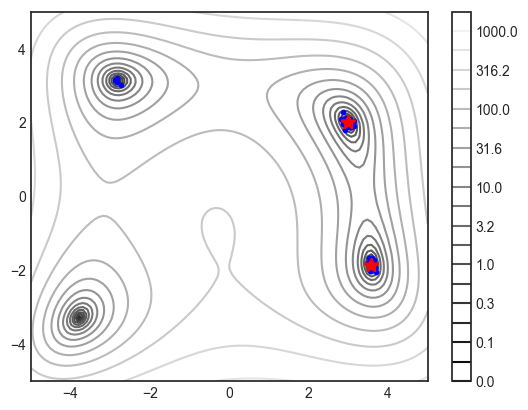

In [28]:
x = np.linspace(-L,L,d)
y = np.linspace(-L,L,d)
plt = plot_contour(x,y,cost_plot,data=samples[0].cpu(), contour_scale=100, figsize=5,log_norm=log_norm)
plt.plot(ttgo_optimized_k[:,0].cpu(),ttgo_optimized_k[:,1].cpu(),'*r',markersize=10)
# plt.plot(best_estimate[:,0].cpu(),best_estimate[:,1].cpu(),'*r',markersize=10)

# plt.title("Cost")

#plt.title(r"Himmelblau: $z=(x^2+y-{})^2+(x+y^2-{})^2$".format(a,b))
#plt.title(r"Rosenbrock: $z=(x-1)^2+100 (y-x^2)^2$".format(11,7))

# plt.savefig('rosenbrock2D_a_99.png',pad_inches=0.01, dpi=300)
# plt.savefig('Himmelblau2D_99.png',pad_inches=0.01, dpi=300)
# plt.savefig('Sine2D_a_0.png',pad_inches=0.01, dpi=300)